In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import tqdm
from torch.optim import Adam
import matplotlib.pyplot as plt
import seaborn as sns

from lib.model import FNO1d
from lib.dataset import PDEDatasetAll2All
from lib.utils import relative_l2_error

In [2]:
sns.set_context("paper")
sns.set_style("whitegrid")

In [3]:
torch.manual_seed(0)
np.random.seed(0)

In [4]:
BATCH_SIZE = 1024
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
dataset_train = (
    PDEDatasetAll2All("data/train_allen_cahn_fourier.npz", device=DEVICE)
    + PDEDatasetAll2All("data/train_allen_cahn_gmm.npz", device=DEVICE)
    + PDEDatasetAll2All("data/train_allen_cahn_piecewise.npz", device=DEVICE)
)

print("Train dataset size:", len(dataset_train))

Train dataset size: 54000


In [6]:
training_data, validation_data = torch.utils.data.random_split(
    dataset_train, [int(0.8 * len(dataset_train)), int(0.2 * len(dataset_train))]
)

In [7]:
train_data_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
val_data_loader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
learning_rate = 0.0005
epochs = 100
step_size = 20
gamma = 0.5

In [9]:
modes = 16
width = 64
layers = 4
fno = FNO1d(modes, width, layers).to(DEVICE)  # model

In [10]:
optimizer = Adam(fno.parameters(), lr=learning_rate, weight_decay=1e-5)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = step_size, eta_min=1e-6)

In [11]:
def loss_f(output: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    return relative_l2_error(output, target, dim=-1).sum()

In [12]:
metrics = {
    "training_loss": [],
    "validation_loss": [],
    "lr": [],
}

In [13]:
best_val_loss = float("inf")
progress_bar = tqdm.tqdm(range(epochs))
for epoch in progress_bar:
    fno.train()
    train_loss = 0.0
    for i, (dt, eps, input, target) in enumerate(train_data_loader):
        optimizer.zero_grad()
        prediction = fno(input, dt, eps).squeeze(-1)

        loss = loss_f(prediction, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(training_data)

    metrics["training_loss"].append(train_loss)
    metrics["lr"].append(scheduler.get_last_lr())

    # Compute validation loss
    fno.eval()
    validation_relative_l2 = 0.0
    for i, (dt, eps, input, target) in enumerate(val_data_loader):
        with torch.no_grad():
            prediction = fno(input, dt, eps).squeeze(-1)

        loss = relative_l2_error(prediction, target, dim=-1).sum()
        validation_relative_l2 += loss.item()

    validation_relative_l2 /= len(validation_data)
    metrics["validation_loss"].append(validation_relative_l2)

    # scheduler.step(validation_relative_l2)
    scheduler.step()

    # Save best model
    if validation_relative_l2 < best_val_loss:
        best_val_loss = validation_relative_l2
        torch.save(fno.state_dict(), "models/tfno_model.pth")

    # Update progress bar
    progress_bar.set_postfix(
        {
            "train_loss": train_loss,
            "val_loss": validation_relative_l2,
            "best_val_loss": best_val_loss,
            "lr": scheduler.get_last_lr(),
        },
    )


100%|██████████| 100/100 [22:20<00:00, 13.41s/it, train_loss=0.0327, val_loss=0.017, best_val_loss=0.017, lr=[0.0005]]                 


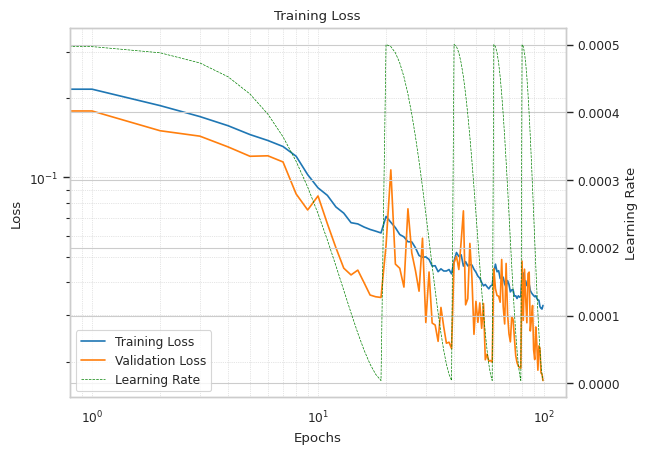

In [14]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

l1 = ax1.loglog(metrics["training_loss"], label="Training Loss")
l2 = ax1.loglog(metrics["validation_loss"], label="Validation Loss")
l3 = ax2.plot(metrics["lr"], label="Learning Rate", color="green", linestyle="--", linewidth=0.5)

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax2.set_ylabel("Learning Rate")
plt.title("Training Loss")

plt.legend(l1 + l2 + l3, [l.get_label() for l in l1 + l2 + l3])
ax1.grid(True, which="both", ls=":", linewidth=0.5)
plt.show()

In [15]:
time_pairs = [(0, 1), (0, 2), (0, 3), (0, 4)]
dataset_test = (
    PDEDatasetAll2All(
        "data/test_allen_cahn_fourier.npz", device=DEVICE, time_pairs=time_pairs
    )
    + PDEDatasetAll2All(
        "data/test_allen_cahn_gmm.npz", device=DEVICE, time_pairs=time_pairs
    )
    + PDEDatasetAll2All(
        "data/test_allen_cahn_piecewise.npz", device=DEVICE, time_pairs=time_pairs
    )
)
test_data_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

In [16]:
fno.eval()
progress_bar = tqdm.tqdm(test_data_loader)

with torch.no_grad():
    test_relative_l2 = 0.0
    for i, (dt, eps, input, target) in enumerate(progress_bar):
        prediction = fno(input, dt, eps).squeeze(-1)

        loss = relative_l2_error(prediction, target, dim=-1).sum()
        test_relative_l2 += loss.item()
    test_relative_l2 /= len(dataset_test)

print(rf"Test relative L2 error: {test_relative_l2}")

100%|██████████| 4/4 [00:00<00:00,  6.31it/s]

Test relative L2 error: 0.019965534740024143


In [17]:
time_pairs = [(0, 4)]
dataset_test = (
    PDEDatasetAll2All(
        "data/test_allen_cahn_fourier.npz", device=DEVICE, time_pairs=time_pairs
    )
    + PDEDatasetAll2All(
        "data/test_allen_cahn_gmm.npz", device=DEVICE, time_pairs=time_pairs
    )
    + PDEDatasetAll2All(
        "data/test_allen_cahn_piecewise.npz", device=DEVICE, time_pairs=time_pairs
    )
)
test_data_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

In [18]:
fno.eval()
progress_bar = tqdm.tqdm(test_data_loader)

with torch.no_grad():
    test_relative_l2 = 0.0
    for i, (dt, eps, input, target) in enumerate(progress_bar):
        prediction = fno(input, dt, eps).squeeze(-1)

        loss = relative_l2_error(prediction, target, dim=-1).sum()
        test_relative_l2 += loss.item()
    test_relative_l2 /= len(dataset_test)

print(rf"Test relative L2 error (Only prediction t_0 -> t_1): {test_relative_l2}")

100%|██████████| 1/1 [00:00<00:00,  6.39it/s]

Test relative L2 error (Only prediction t_0 -> t_1): 0.02051365746392144


In [19]:
time_pairs = [(0, 1), (0, 2), (0, 3), (0, 4)]
dataset_ood = (
    PDEDatasetAll2All(
        "data/OOD_allen_cahn.npz", device=DEVICE, time_pairs=time_pairs
    )
)
ood_data_loader = DataLoader(dataset_ood, batch_size=BATCH_SIZE, shuffle=True)

In [21]:
fno.eval()
progress_bar = tqdm.tqdm(ood_data_loader)

with torch.no_grad():
    ood_relative_l2 = 0.0
    for i, (dt, eps, input, target) in enumerate(progress_bar):
        prediction = fno(input, dt, eps).squeeze(-1)

        loss = relative_l2_error(prediction, target, dim=-1).sum()
        ood_relative_l2 += loss.item()
    ood_relative_l2 /= len(dataset_ood)

print(rf"OOD relative L2 error: {ood_relative_l2}")

100%|██████████| 2/2 [00:00<00:00,  6.13it/s]

OOD relative L2 error: 0.20192164611816407
